In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
#build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
ctoi = {c:i+1 for i,c in enumerate(chars)}
ctoi['.'] = 0
itoc = {i:c for c,i in ctoi.items()}
print(itoc)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
#build the dataset

block_size = 3 # context len of how many chars do we take to predict the next one ?
X, Y = [], []

for w in words[:5]:
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = ctoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itoc[i] for i in context), '------->', itoc[ix])
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... -------> e
..e -------> m
.em -------> m
emm -------> a
mma -------> .
olivia
... -------> o
..o -------> l
.ol -------> i
oli -------> v
liv -------> i
ivi -------> a
via -------> .
ava
... -------> a
..a -------> v
.av -------> a
ava -------> .
isabella
... -------> i
..i -------> s
.is -------> a
isa -------> b
sab -------> e
abe -------> l
bel -------> l
ell -------> a
lla -------> .
sophia
... -------> s
..s -------> o
.so -------> p
sop -------> h
oph -------> i
phi -------> a
hia -------> .


In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
C

tensor([[ 1.5674, -0.2373],
        [-0.0274, -1.1008],
        [ 0.2859, -0.0296],
        [-1.5471,  0.6049],
        [ 0.0791,  0.9046],
        [-0.4713,  0.7868],
        [-0.3284, -0.4330],
        [ 1.3729,  2.9334],
        [ 1.5618, -1.6261],
        [ 0.6772, -0.8404],
        [ 0.9849, -0.1484],
        [-1.4795,  0.4483],
        [-0.0707,  2.4968],
        [ 2.4448, -0.6701],
        [-1.2199,  0.3031],
        [-1.0725,  0.7276],
        [ 0.0511,  1.3095],
        [-0.8022, -0.8504],
        [-1.8068,  1.2523],
        [ 0.1476, -1.0006],
        [-0.5030, -1.0660],
        [ 0.8480,  2.0275],
        [-0.1158, -1.2078],
        [-1.0406, -1.5367],
        [-0.5132,  0.2961],
        [-1.4904, -0.2838],
        [ 0.2569,  0.2130]])

In [ ]:
C[5] == F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([True, True])

In [ ]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [ ]:
# hidden layer

W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)

# torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1).shape
# torch.cat(torch.unbind(emb, 1), 1).shape
# h = emb.view(-1, 6) @ W1 + b1
h = emb.view(emb.shape[0], 6) @ W1 + b1
h.shape

torch.Size([32, 100])

In [ ]:
# final layer

W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

logits = h @ W2 + b2
# counts = logits.exp()
# probs = counts / counts.sum(1, keepdims=True)
# loss = -probs[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y)
loss

tensor(61.7389)

In [ ]:
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

sum(p.nelement() for p in parameters) # no. of parameters

3481

In [ ]:
# --------- making it respectable ------------

In [ ]:
#build the dataset

block_size = 3 # context len of how many chars do we take to predict the next one ?
X, Y = [], []

for w in words:
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = ctoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itoc[i] for i in context), '------->', itoc[ix])
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
# build the dataset

def build_dataset(words):
  block_size = 3
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = ctoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [ ]:
g = torch.Generator().manual_seed(214748364567457)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

sum(p.nelement() for p in parameters) # no. of parameters

11897

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
lri = []
lossi = []

for i in range(50000):
  # mini batch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = emb.view(emb.shape[0], 30) @ W1 + b1 # (32, 100)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # lr = lrs[i]
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  # lossi.append(loss.item())

# print(loss.item())

In [ ]:
# plt.plot(lri, lossi)

In [ ]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3867, grad_fn=<NllLossBackward0>)

In [ ]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3996, grad_fn=<NllLossBackward0>)

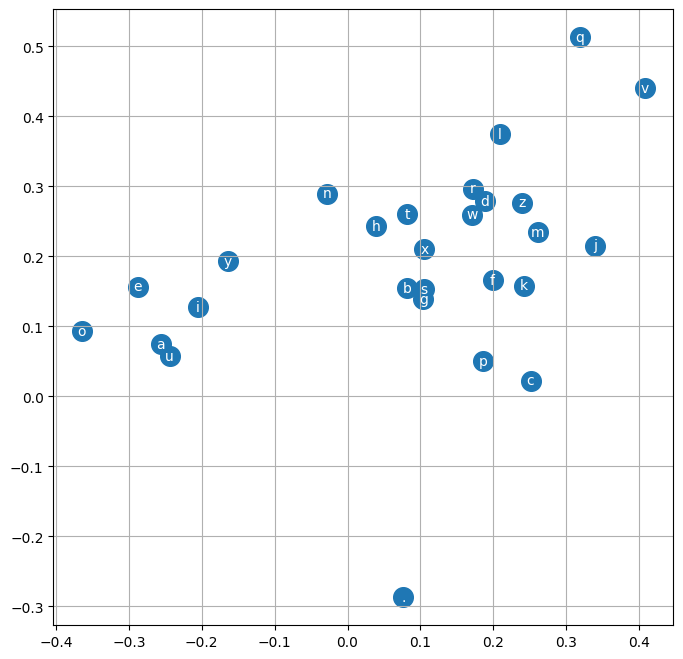

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itoc[i], ha="center", va="center", color="white")
plt.grid('minor')

In [ ]:
# sampling from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itoc[i] for i in out))


mriaghmyazhieel.
ndynyah.
rethrstendrlen.
adered.
eliighmioren.
edeliestanarlelyzimrokelin.
shurergahiries.
kin.
reellelanterofiuzanged.
ruy.
juemeka.
kay.
muskeyla.
hil.
calyansuf.
zakelveuten.
cre.
kiveaodu.
pordinneyloh.
bhizpeil.
